In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pyrosm
import contextily as cx 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


'1.1.2'

In [2]:
filename = "01-04-23.csv"

In [3]:
df = pd.read_csv(filename, names=["rooms", "area", "rent", "street", "zip_code", "latitude", "longitude"], skiprows=1)

In [4]:
df

,rooms,area,rent,street,zip_code,latitude,longitude
0,1,26,8650,Finsensvej,2000,55.681189,12.518624
1,2,38,11800,Finsensvej,2000,55.681189,12.518624
2,1,41,4492,Nordre Fasanvej,2000,55.695098,12.533609
3,1,41,4478,Robert Jacobsens Vej,2300,55.618704,12.573169
4,1,47,9600,Torvegade,1400,55.671192,12.593326
...,...,...,...,...,...,...,...
1881,3,68,5700,Birkegade,2200,55.690001,12.558017
1882,2,54,6800,Århusgade,2100,55.705868,12.578911
1883,2,66,5260,Vigerslevvej,2500,55.648242,12.492380
1884,3,78,4900,Solnavej,2860,55.743446,12.501736


In [5]:
df.columns

Index(['rooms', 'area', 'rent', 'street', 'zip_code', 'latitude', 'longitude'], dtype='object')

# Data anomalities

In [6]:
# Uniqueness
duplicates = df.duplicated()
duplicates_df = df[duplicates]

In [7]:
# Get number of duplicates
df.duplicated().value_counts()

False    1452
True      434
dtype: int64

In [8]:
# Display the duplicates - Note: They are not necessarily duplicates as street/door numnber is not included.
duplicates_df.sort_values(by=['street', 'area'])

,rooms,area,rent,street,zip_code,latitude,longitude
1464,4,97,14600,Aage Knudsens Strøg,2610,55.688955,12.449246
1599,4,97,14600,Aage Knudsens Strøg,2610,55.688955,12.449246
1677,4,97,14400,Aage Knudsens Strøg,2610,55.688955,12.449246
1057,4,98,14300,Aage Knudsens Strøg,2610,55.688955,12.449246
1357,4,98,14400,Aage Knudsens Strøg,2610,55.688955,12.449246
...,...,...,...,...,...,...,...
908,4,119,15800,Ørestads Boulevard,2300,55.636709,12.582897
1331,4,129,15900,Ørestads Boulevard,2300,55.636709,12.582897
459,1,38,9300,Øresundsvej,2300,55.660626,12.613696
617,1,38,9300,Øresundsvej,2300,55.660626,12.613696


In [9]:
# Get number of different zip codes
df['zip_code'].value_counts()

2300    741
2610    269
2450    221
2700    123
2500     79
       ... 
1254      1
1660      1
1203      1
1738      1
1458      1
Name: zip_code, Length: 81, dtype: int64

In [10]:
# Get number of nan values per columns
for col in df.columns:
    print(col)
    print(df[col].isnull().values.sum())

rooms
0
area
0
rent
0
street
0
zip_code
0
latitude
6
longitude
6


In [11]:
# Dataframe with nans dropped
df2 = df.dropna()

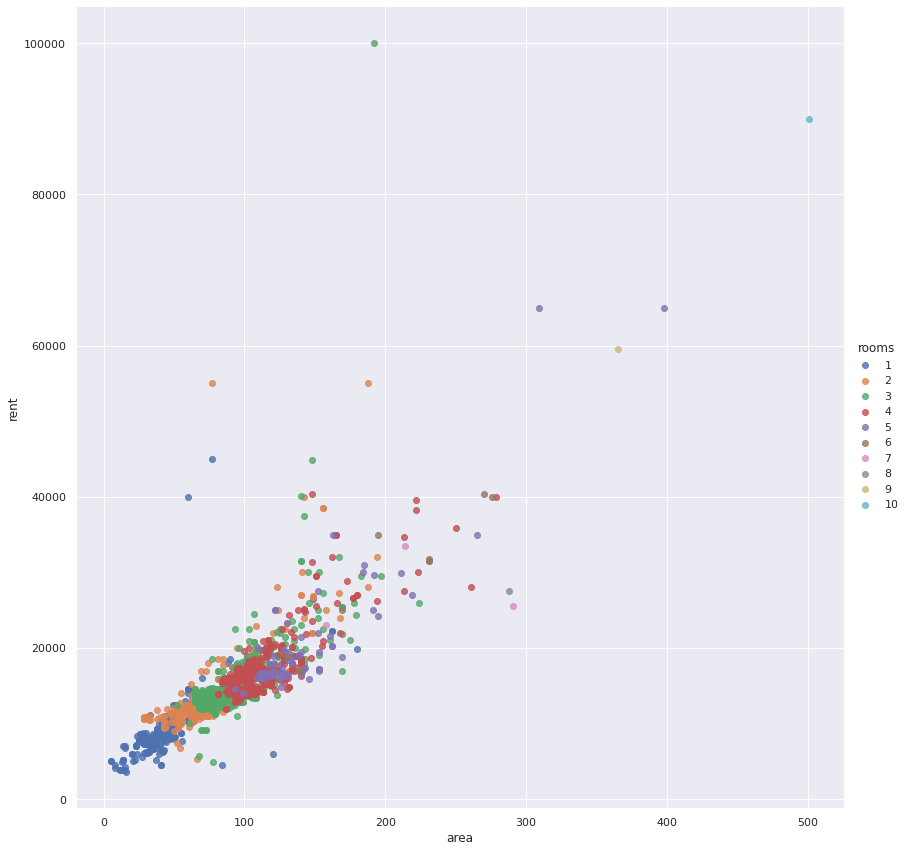

In [12]:
# Plotting 

import seaborn as sns

sns.set(rc={'figure.figsize':(26,12)})
sns.lmplot('area', 'rent', data=df2, hue='rooms', fit_reg=False, height=12, aspect=1)

plt.show()

# Geopandas

In [15]:
#geometry = gdp.points_from_xy(df2.longitude, df2.latitude, crs="EPSG:4326")
gdf = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude,df2.latitude, crs="EPSG:4326"))

In [16]:
gdf

,rooms,area,rent,street,zip_code,latitude,longitude,geometry
0,1,26,8650,Finsensvej,2000,55.681189,12.518624,POINT (12.51862 55.68119)
1,2,38,11800,Finsensvej,2000,55.681189,12.518624,POINT (12.51862 55.68119)
2,1,41,4492,Nordre Fasanvej,2000,55.695098,12.533609,POINT (12.53361 55.69510)
3,1,41,4478,Robert Jacobsens Vej,2300,55.618704,12.573169,POINT (12.57317 55.61870)
4,1,47,9600,Torvegade,1400,55.671192,12.593326,POINT (12.59333 55.67119)
...,...,...,...,...,...,...,...,...
1881,3,68,5700,Birkegade,2200,55.690001,12.558017,POINT (12.55802 55.69000)
1882,2,54,6800,Århusgade,2100,55.705868,12.578911,POINT (12.57891 55.70587)
1883,2,66,5260,Vigerslevvej,2500,55.648242,12.492380,POINT (12.49238 55.64824)
1884,3,78,4900,Solnavej,2860,55.743446,12.501736,POINT (12.50174 55.74345)


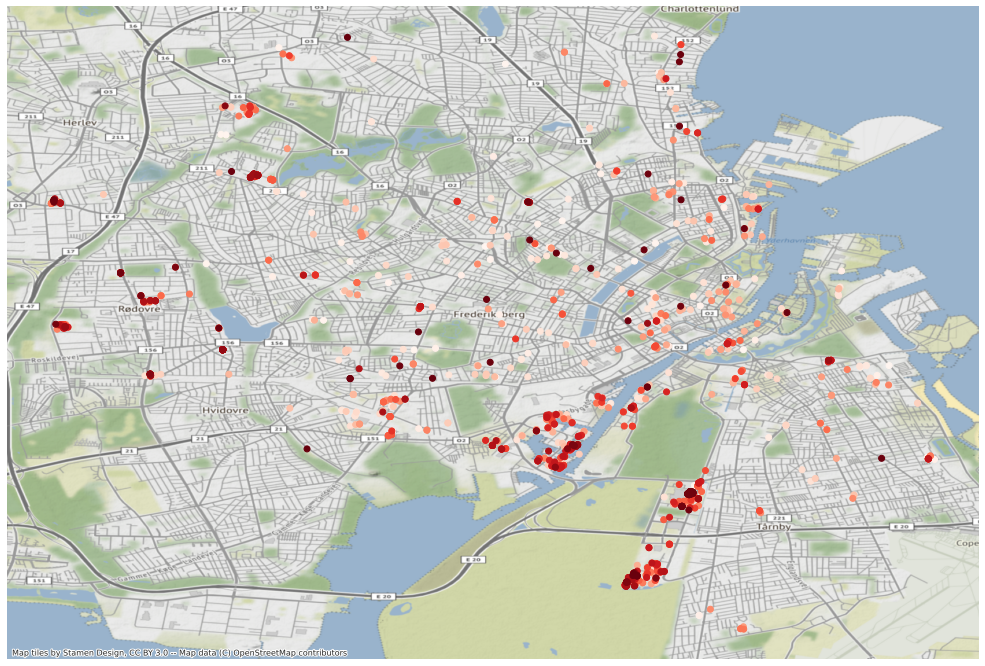

In [32]:
ax = gdf.plot(c=gdf["rent"], cmap='Reds', legend=True) #color="black")
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf.crs)

cmap = mpl.cm.get_cmap('cool')
cmap.set_under('red')